In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, sequence, dimension)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
class GRU(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.gru = nn.GRU(config.input_size, config.hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(config.hidden_size//2, config.output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        gru_out, hidden = self.gru(x, hidden)
        last_output = gru_out[:, -1, :]
        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

# trainer 구현

In [11]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")
    
  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [12]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 3000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  input_size = 19        # 처음 input의 차원의 개수 (feature수와 같다)
  hidden_size=512        # GRU hidden vector size
  output_size = 2        # output 차원의 개수

config = Config()

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [14]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [15]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


In [16]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 3000
failure(1)의 개수 : 1569


In [17]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [18]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [19]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [20]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 2741
Total number of data samples in valid_loader: 913
Total number of data samples in test_loader: 914


In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [22]:
# model, optimizer, loss_function 구현하고 결합시키기
model = GRU(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [23]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/3000_GRU') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 4/4 [00:00<00:00, 561.81it/s]


Model saved
TRAIN LOSS = 0.0025469805584559255, TRAIN ACC = 0.6763954761036118, 
VALID LOSS = 0.002575720061608238, VALID ACC = 0.7075575027382256, 
epoch 2


100%|██████████| 4/4 [00:00<00:00, 563.64it/s]


Model saved
TRAIN LOSS = 0.00220483741548017, TRAIN ACC = 0.7274717256475739, 
VALID LOSS = 0.0024353409387979164, VALID ACC = 0.7119386637458927, 
epoch 3


100%|██████████| 4/4 [00:00<00:00, 554.05it/s]


Model saved
TRAIN LOSS = 0.0020902258381709613, TRAIN ACC = 0.748996716526815, 
VALID LOSS = 0.0022689984766572618, VALID ACC = 0.7491785323110625, 
epoch 4


100%|██████████| 4/4 [00:00<00:00, 73.35it/s]


TRAIN LOSS = 0.0019399944620817867, TRAIN ACC = 0.7570229843122948, 
VALID LOSS = 0.0022178842295430446, VALID ACC = 0.7437020810514786, 
epoch 5


100%|██████████| 4/4 [00:00<00:00, 579.94it/s]


TRAIN LOSS = 0.0019287808191076068, TRAIN ACC = 0.7614009485589202, 
VALID LOSS = 0.0021545989163472908, VALID ACC = 0.7382256297918949, 
epoch 6


100%|██████████| 4/4 [00:00<00:00, 586.02it/s]


Model saved
TRAIN LOSS = 0.0018432256797942224, TRAIN ACC = 0.7679678949288581, 
VALID LOSS = 0.002136062361455042, VALID ACC = 0.7513691128148959, 
epoch 7


100%|██████████| 4/4 [00:00<00:00, 584.29it/s]


TRAIN LOSS = 0.0018031215067546502, TRAIN ACC = 0.7723458591754834, 
VALID LOSS = 0.002078636093442568, VALID ACC = 0.7437020810514786, 
epoch 8


100%|██████████| 4/4 [00:00<00:00, 580.53it/s]


Model saved
TRAIN LOSS = 0.0017643147730905615, TRAIN ACC = 0.7763589930682233, 
VALID LOSS = 0.001939622524142396, VALID ACC = 0.7546549835706462, 
epoch 9


100%|██████████| 4/4 [00:00<00:00, 581.96it/s]


Model saved
TRAIN LOSS = 0.001685738726629475, TRAIN ACC = 0.7741700109449107, 
VALID LOSS = 0.00190642985300062, VALID ACC = 0.76013143483023, 
epoch 10


100%|██████████| 4/4 [00:00<00:00, 581.96it/s]


TRAIN LOSS = 0.0015954410168690562, TRAIN ACC = 0.7825611090842758, 
VALID LOSS = 0.0019255014460815396, VALID ACC = 0.7546549835706462, 
epoch 11


100%|██████████| 4/4 [00:00<00:00, 583.88it/s]


Model saved
TRAIN LOSS = 0.001595410496942408, TRAIN ACC = 0.7840204304998176, 
VALID LOSS = 0.0018289567737433108, VALID ACC = 0.7699890470974808, 
epoch 12


100%|██████████| 4/4 [00:00<00:00, 576.44it/s]


TRAIN LOSS = 0.0015307034901657578, TRAIN ACC = 0.7894928858080993, 
VALID LOSS = 0.0019166321704839433, VALID ACC = 0.7656078860898138, 
epoch 13


100%|██████████| 4/4 [00:00<00:00, 573.42it/s]


TRAIN LOSS = 0.0015959295422784694, TRAIN ACC = 0.7902225465158701, 
VALID LOSS = 0.0018865424009429665, VALID ACC = 0.768893756845564, 
epoch 14


100%|██████████| 4/4 [00:00<00:00, 578.88it/s]


TRAIN LOSS = 0.0015415640500982676, TRAIN ACC = 0.7854797519153593, 
VALID LOSS = 0.0017179930980469286, VALID ACC = 0.7667031763417306, 
epoch 15


100%|██████████| 4/4 [00:00<00:00, 587.19it/s]


Model saved
TRAIN LOSS = 0.001441023354980903, TRAIN ACC = 0.7894928858080993, 
VALID LOSS = 0.0015476166810289532, VALID ACC = 0.7710843373493976, 
epoch 16


100%|██████████| 4/4 [00:00<00:00, 581.39it/s]


TRAIN LOSS = 0.001340343433764241, TRAIN ACC = 0.7993433053630062, 
VALID LOSS = 0.0016129759159693973, VALID ACC = 0.7634173055859803, 
epoch 17


100%|██████████| 4/4 [00:00<00:00, 577.83it/s]


Model saved
TRAIN LOSS = 0.0013321841211051063, TRAIN ACC = 0.8088288945640277, 
VALID LOSS = 0.0015270443304736668, VALID ACC = 0.7940854326396495, 
epoch 18


100%|██████████| 4/4 [00:00<00:00, 583.74it/s]


TRAIN LOSS = 0.0013575964776845971, TRAIN ACC = 0.8128420284567676, 
VALID LOSS = 0.0016310532278455752, VALID ACC = 0.7940854326396495, 
epoch 19


100%|██████████| 4/4 [00:00<00:00, 585.08it/s]


Model saved
TRAIN LOSS = 0.0012202695615532537, TRAIN ACC = 0.8259759211966435, 
VALID LOSS = 0.0014834163092313434, VALID ACC = 0.8072289156626506, 
epoch 20


100%|██████████| 4/4 [00:00<00:00, 574.39it/s]


TRAIN LOSS = 0.0011873945338323315, TRAIN ACC = 0.8303538854432689, 
VALID LOSS = 0.0014657630847291644, VALID ACC = 0.8039430449069004, 
epoch 21


100%|██████████| 4/4 [00:00<00:00, 581.15it/s]


Model saved
TRAIN LOSS = 0.0012021673743370805, TRAIN ACC = 0.8358263407515505, 
VALID LOSS = 0.00153897195107835, VALID ACC = 0.8192771084337349, 
epoch 22


100%|██████████| 4/4 [00:00<00:00, 580.95it/s]


TRAIN LOSS = 0.0011598403025003994, TRAIN ACC = 0.8412987960598322, 
VALID LOSS = 0.0014647599248478734, VALID ACC = 0.8192771084337349, 
epoch 23


100%|██████████| 4/4 [00:00<00:00, 588.47it/s]


Model saved
TRAIN LOSS = 0.0010589723635311328, TRAIN ACC = 0.8496898941991974, 
VALID LOSS = 0.0014527748539831656, VALID ACC = 0.8203723986856517, 
epoch 24


100%|██████████| 4/4 [00:00<00:00, 571.22it/s]


Model saved
TRAIN LOSS = 0.0010271150834888318, TRAIN ACC = 0.8537030280919372, 
VALID LOSS = 0.0013819297394120549, VALID ACC = 0.8247535596933188, 
epoch 25


100%|██████████| 4/4 [00:00<00:00, 579.74it/s]


TRAIN LOSS = 0.0010007405011421657, TRAIN ACC = 0.8529733673841664, 
VALID LOSS = 0.0013909646088557332, VALID ACC = 0.8225629791894852, 
epoch 26


100%|██████████| 4/4 [00:00<00:00, 574.17it/s]


Model saved
TRAIN LOSS = 0.0010158710130067344, TRAIN ACC = 0.8668369208318132, 
VALID LOSS = 0.001310804065190427, VALID ACC = 0.8313253012048193, 
epoch 27


100%|██████████| 4/4 [00:00<00:00, 583.76it/s]


Model saved
TRAIN LOSS = 0.0009682495493560061, TRAIN ACC = 0.8799708135716892, 
VALID LOSS = 0.001421546851165454, VALID ACC = 0.8466593647316539, 
epoch 28


100%|██████████| 4/4 [00:00<00:00, 569.96it/s]


Model saved
TRAIN LOSS = 0.000875906825109104, TRAIN ACC = 0.8931047063115651, 
VALID LOSS = 0.0013885471280276579, VALID ACC = 0.8521358159912377, 
epoch 29


100%|██████████| 4/4 [00:00<00:00, 580.51it/s]


Model saved
TRAIN LOSS = 0.0009565053902503914, TRAIN ACC = 0.8931047063115651, 
VALID LOSS = 0.0013251284714726995, VALID ACC = 0.8674698795180723, 
epoch 30


100%|██████████| 4/4 [00:00<00:00, 554.62it/s]


TRAIN LOSS = 0.0008445148570656733, TRAIN ACC = 0.900401313389274, 
VALID LOSS = 0.001379946432395676, VALID ACC = 0.859802847754655, 
epoch 31


100%|██████████| 4/4 [00:00<00:00, 579.34it/s]


Model saved
TRAIN LOSS = 0.000779035936433527, TRAIN ACC = 0.9109813936519519, 
VALID LOSS = 0.0012319781955205074, VALID ACC = 0.8838992332968236, 
epoch 32


100%|██████████| 4/4 [00:00<00:00, 563.35it/s]


TRAIN LOSS = 0.000735330885015931, TRAIN ACC = 0.9149945275446917, 
VALID LOSS = 0.0011837157825781246, VALID ACC = 0.8795180722891566, 
epoch 33


100%|██████████| 4/4 [00:00<00:00, 492.74it/s]


Model saved
TRAIN LOSS = 0.0006969719527194814, TRAIN ACC = 0.9270339292229114, 
VALID LOSS = 0.001178231943084533, VALID ACC = 0.8926615553121577, 
epoch 34


100%|██████████| 4/4 [00:00<00:00, 579.70it/s]


TRAIN LOSS = 0.0006402214647252731, TRAIN ACC = 0.9281284202845677, 
VALID LOSS = 0.0012543081486473208, VALID ACC = 0.8871851040525739, 
epoch 35


100%|██████████| 4/4 [00:00<00:00, 570.48it/s]


TRAIN LOSS = 0.0007186830533068356, TRAIN ACC = 0.9175483400218898, 
VALID LOSS = 0.0013384108083793916, VALID ACC = 0.8718510405257394, 
epoch 36


100%|██████████| 4/4 [00:00<00:00, 575.25it/s]


TRAIN LOSS = 0.0007016630187516489, TRAIN ACC = 0.922655964976286, 
VALID LOSS = 0.0013104080990658663, VALID ACC = 0.8838992332968236, 
epoch 37


100%|██████████| 4/4 [00:00<00:00, 571.74it/s]


TRAIN LOSS = 0.0006965868003783283, TRAIN ACC = 0.9215614739146297, 
VALID LOSS = 0.0011138583554887302, VALID ACC = 0.8817086527929902, 
epoch 38


100%|██████████| 4/4 [00:00<00:00, 551.56it/s]


TRAIN LOSS = 0.0005094548758691525, TRAIN ACC = 0.9470995986866108, 
VALID LOSS = 0.0012250846702715652, VALID ACC = 0.8882803943044907, 
epoch 39


100%|██████████| 4/4 [00:00<00:00, 397.58it/s]


TRAIN LOSS = 0.00049665683607949, TRAIN ACC = 0.9496534111638089, 
VALID LOSS = 0.0011734631797961834, VALID ACC = 0.8871851040525739, 
epoch 40


100%|██████████| 4/4 [00:00<00:00, 428.06it/s]


TRAIN LOSS = 0.00046068469360769775, TRAIN ACC = 0.9540313754104341, 
VALID LOSS = 0.0013497410278853032, VALID ACC = 0.8838992332968236, 
epoch 41


100%|██████████| 4/4 [00:00<00:00, 438.61it/s]


Model saved
TRAIN LOSS = 0.0004911311392103917, TRAIN ACC = 0.9536665450565487, 
VALID LOSS = 0.0012033549091510418, VALID ACC = 0.904709748083242, 
epoch 42


100%|██████████| 4/4 [00:00<00:00, 455.41it/s]


TRAIN LOSS = 0.0004230986455634144, TRAIN ACC = 0.9584093396570594, 
VALID LOSS = 0.0012829755182986976, VALID ACC = 0.891566265060241, 
epoch 43


100%|██████████| 4/4 [00:00<00:00, 457.72it/s]


TRAIN LOSS = 0.0006593426554275228, TRAIN ACC = 0.9346953666545057, 
VALID LOSS = 0.0013487605543282834, VALID ACC = 0.882803943044907, 
epoch 44


100%|██████████| 4/4 [00:00<00:00, 441.35it/s]


TRAIN LOSS = 0.0005222920223728056, TRAIN ACC = 0.9470995986866108, 
VALID LOSS = 0.0012063099742588574, VALID ACC = 0.8937568455640745, 
epoch 45


100%|██████████| 4/4 [00:00<00:00, 433.30it/s]


TRAIN LOSS = 0.0004378989643312988, TRAIN ACC = 0.9569500182415177, 
VALID LOSS = 0.0011321392077605801, VALID ACC = 0.9014238773274917, 
epoch 46


100%|██████████| 4/4 [00:00<00:00, 444.45it/s]


Model saved
TRAIN LOSS = 0.0003545201216701694, TRAIN ACC = 0.9675300985041956, 
VALID LOSS = 0.0011954538989302102, VALID ACC = 0.9090909090909091, 
epoch 47


100%|██████████| 4/4 [00:00<00:00, 461.84it/s]


TRAIN LOSS = 0.0003332495512709223, TRAIN ACC = 0.9657059467347683, 
VALID LOSS = 0.001238161704104153, VALID ACC = 0.9025191675794085, 
epoch 48


100%|██████████| 4/4 [00:00<00:00, 435.65it/s]


TRAIN LOSS = 0.00028946069101485315, TRAIN ACC = 0.9715432323969354, 
VALID LOSS = 0.0016205897728166863, VALID ACC = 0.9003285870755751, 
epoch 49


100%|██████████| 4/4 [00:00<00:00, 419.50it/s]


TRAIN LOSS = 0.00034857457874030886, TRAIN ACC = 0.9638817949653411, 
VALID LOSS = 0.0016069552592876055, VALID ACC = 0.8806133625410734, 
epoch 50


100%|██████████| 4/4 [00:00<00:00, 451.05it/s]


TRAIN LOSS = 0.00029591104407808026, TRAIN ACC = 0.9740970448741335, 
VALID LOSS = 0.001330162175122122, VALID ACC = 0.904709748083242, 
epoch 51


100%|██████████| 4/4 [00:00<00:00, 458.80it/s]


TRAIN LOSS = 0.0002613995225596541, TRAIN ACC = 0.9755563662896753, 
VALID LOSS = 0.0013422322299368149, VALID ACC = 0.9003285870755751, 
epoch 52


100%|██████████| 4/4 [00:00<00:00, 440.16it/s]


TRAIN LOSS = 0.0002588812222405969, TRAIN ACC = 0.9770156877052171, 
VALID LOSS = 0.0016185788831470569, VALID ACC = 0.8926615553121577, 
epoch 53


100%|██████████| 4/4 [00:00<00:00, 459.81it/s]


TRAIN LOSS = 0.00025698718598227306, TRAIN ACC = 0.9770156877052171, 
VALID LOSS = 0.001723061222889076, VALID ACC = 0.8904709748083242, 
epoch 54


100%|██████████| 4/4 [00:00<00:00, 460.33it/s]


Model saved
TRAIN LOSS = 0.00018593697342851744, TRAIN ACC = 0.983582634075155, 
VALID LOSS = 0.0015451819651228706, VALID ACC = 0.9134720700985761, 
epoch 55


100%|██████████| 4/4 [00:00<00:00, 453.89it/s]


TRAIN LOSS = 0.00020542976217781354, TRAIN ACC = 0.9828529733673842, 
VALID LOSS = 0.001881333522963759, VALID ACC = 0.8926615553121577, 
epoch 56


100%|██████████| 4/4 [00:00<00:00, 442.15it/s]


TRAIN LOSS = 0.00026603533170467655, TRAIN ACC = 0.9770156877052171, 
VALID LOSS = 0.001474413070072872, VALID ACC = 0.8992332968236583, 
epoch 57


100%|██████████| 4/4 [00:00<00:00, 451.84it/s]


TRAIN LOSS = 0.00019879403209129592, TRAIN ACC = 0.9821233126596133, 
VALID LOSS = 0.0015978055219660714, VALID ACC = 0.9101861993428259, 
epoch 58


100%|██████████| 4/4 [00:00<00:00, 416.79it/s]


TRAIN LOSS = 0.00017581452927812092, TRAIN ACC = 0.983582634075155, 
VALID LOSS = 0.0019796193298870475, VALID ACC = 0.891566265060241, 
epoch 59


100%|██████████| 4/4 [00:00<00:00, 458.06it/s]


TRAIN LOSS = 0.00037576231272365873, TRAIN ACC = 0.9671652681503101, 
VALID LOSS = 0.0014939301638065268, VALID ACC = 0.9025191675794085, 
epoch 60


100%|██████████| 4/4 [00:00<00:00, 416.86it/s]


TRAIN LOSS = 0.00030340415360022093, TRAIN ACC = 0.9715432323969354, 
VALID LOSS = 0.0015210720821643843, VALID ACC = 0.8981380065717415, 
epoch 61


100%|██████████| 4/4 [00:00<00:00, 449.08it/s]


TRAIN LOSS = 0.0002365229662884243, TRAIN ACC = 0.9806639912440716, 
VALID LOSS = 0.0016455047265070554, VALID ACC = 0.895947426067908, 
epoch 62


100%|██████████| 4/4 [00:00<00:00, 437.03it/s]


TRAIN LOSS = 0.0002671159349928281, TRAIN ACC = 0.9762860269974462, 
VALID LOSS = 0.0015453990193865254, VALID ACC = 0.8937568455640745, 
epoch 63


100%|██████████| 4/4 [00:00<00:00, 394.86it/s]


Model saved
TRAIN LOSS = 0.0001360580803529488, TRAIN ACC = 0.9872309376140095, 
VALID LOSS = 0.0014385648912302374, VALID ACC = 0.9156626506024096, 
epoch 64


100%|██████████| 4/4 [00:00<00:00, 532.73it/s]


TRAIN LOSS = 0.0001317114636861943, TRAIN ACC = 0.9886902590295512, 
VALID LOSS = 0.001610573287339226, VALID ACC = 0.9036144578313253, 
epoch 65


100%|██████████| 4/4 [00:00<00:00, 544.22it/s]


TRAIN LOSS = 6.491944515946485e-05, TRAIN ACC = 0.9970813571689164, 
VALID LOSS = 0.0015343631834999494, VALID ACC = 0.9101861993428259, 
epoch 66


100%|██████████| 4/4 [00:00<00:00, 571.59it/s]


TRAIN LOSS = 5.7011291273250846e-05, TRAIN ACC = 0.9959868661072602, 
VALID LOSS = 0.0017608113317604524, VALID ACC = 0.9014238773274917, 
epoch 67


100%|██████████| 4/4 [00:00<00:00, 590.91it/s]


TRAIN LOSS = 3.576632230639436e-05, TRAIN ACC = 0.9985406785844583, 
VALID LOSS = 0.0018498330231172492, VALID ACC = 0.9123767798466593, 
epoch 68


100%|██████████| 4/4 [00:00<00:00, 587.52it/s]


TRAIN LOSS = 4.562233234573916e-05, TRAIN ACC = 0.9970813571689164, 
VALID LOSS = 0.001935806521189043, VALID ACC = 0.9134720700985761, 
epoch 69


100%|██████████| 4/4 [00:00<00:00, 581.86it/s]


TRAIN LOSS = 9.107678980505062e-05, TRAIN ACC = 0.9934330536300621, 
VALID LOSS = 0.0020135318593153687, VALID ACC = 0.9036144578313253, 
epoch 70


100%|██████████| 4/4 [00:00<00:00, 588.47it/s]


TRAIN LOSS = 0.00011824722245841163, TRAIN ACC = 0.9905144107989785, 
VALID LOSS = 0.002033709663681498, VALID ACC = 0.904709748083242, 
epoch 71


100%|██████████| 4/4 [00:00<00:00, 576.71it/s]


TRAIN LOSS = 0.0002783912980493426, TRAIN ACC = 0.9781101787668735, 
VALID LOSS = 0.0018416621272430754, VALID ACC = 0.8992332968236583, 
epoch 72


100%|██████████| 4/4 [00:00<00:00, 580.41it/s]


TRAIN LOSS = 0.00023439782000575263, TRAIN ACC = 0.9792046698285297, 
VALID LOSS = 0.0016377917353190311, VALID ACC = 0.9003285870755751, 
epoch 73


100%|██████████| 4/4 [00:00<00:00, 574.86it/s]


TRAIN LOSS = 0.00019968646133046043, TRAIN ACC = 0.9821233126596133, 
VALID LOSS = 0.0015040890671728997, VALID ACC = 0.9025191675794085, 
epoch 74


100%|██████████| 4/4 [00:00<00:00, 506.45it/s]


TRAIN LOSS = 0.00014602721202269125, TRAIN ACC = 0.9886902590295512, 
VALID LOSS = 0.0016010653345895623, VALID ACC = 0.904709748083242, 
epoch 75


100%|██████████| 4/4 [00:00<00:00, 581.37it/s]


TRAIN LOSS = 0.00011387338881530017, TRAIN ACC = 0.9905144107989785, 
VALID LOSS = 0.0015102161537256062, VALID ACC = 0.9112814895947426, 
epoch 76


100%|██████████| 4/4 [00:00<00:00, 582.64it/s]


TRAIN LOSS = 8.528232873464666e-05, TRAIN ACC = 0.9927033929222912, 
VALID LOSS = 0.0017738980766455158, VALID ACC = 0.9145673603504929, 
epoch 77


100%|██████████| 4/4 [00:00<00:00, 524.34it/s]


TRAIN LOSS = 6.5864825404471e-05, TRAIN ACC = 0.9952572053994893, 
VALID LOSS = 0.0019058515639059645, VALID ACC = 0.904709748083242, 
epoch 78


100%|██████████| 4/4 [00:00<00:00, 588.39it/s]


TRAIN LOSS = 3.757832241603076e-05, TRAIN ACC = 0.9978110178766874, 
VALID LOSS = 0.0017853200696775974, VALID ACC = 0.9123767798466593, 
epoch 79


100%|██████████| 4/4 [00:00<00:00, 588.51it/s]


Model saved
TRAIN LOSS = 1.6237479931546125e-05, TRAIN ACC = 0.9989055089383436, 
VALID LOSS = 0.0019739845365710222, VALID ACC = 0.9167579408543264, 
epoch 80


100%|██████████| 4/4 [00:00<00:00, 581.57it/s]


TRAIN LOSS = 8.878776209346681e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019808661637405445, VALID ACC = 0.9156626506024096, 
epoch 81


100%|██████████| 4/4 [00:00<00:00, 583.76it/s]


Model saved
TRAIN LOSS = 7.85564690225563e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020588104983410203, VALID ACC = 0.9178532311062432, 
epoch 82


100%|██████████| 4/4 [00:00<00:00, 571.18it/s]


Model saved
TRAIN LOSS = 4.8318643753873155e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020646828615391243, VALID ACC = 0.91894852135816, 
epoch 83


100%|██████████| 4/4 [00:00<00:00, 526.91it/s]


Model saved
TRAIN LOSS = 2.971691607702517e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020442230612659766, VALID ACC = 0.9211391018619934, 
epoch 84


100%|██████████| 4/4 [00:00<00:00, 579.02it/s]


Model saved
TRAIN LOSS = 1.9902974589354404e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0021074799757536504, VALID ACC = 0.9222343921139102, 
epoch 85


100%|██████████| 4/4 [00:00<00:00, 585.39it/s]


Model saved
TRAIN LOSS = 1.871724864783969e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020667319099325994, VALID ACC = 0.9233296823658269, 
epoch 86


100%|██████████| 4/4 [00:00<00:00, 581.57it/s]


TRAIN LOSS = 1.860796121616407e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0021841403949691587, VALID ACC = 0.9233296823658269, 
epoch 87


100%|██████████| 4/4 [00:00<00:00, 586.29it/s]


TRAIN LOSS = 1.2033443503569036e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020744768741488588, VALID ACC = 0.9222343921139102, 
epoch 88


100%|██████████| 4/4 [00:00<00:00, 576.38it/s]


TRAIN LOSS = 1.106475160002915e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022299780315532874, VALID ACC = 0.9222343921139102, 
epoch 89


100%|██████████| 4/4 [00:00<00:00, 585.12it/s]


TRAIN LOSS = 8.953491597934478e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022858872862791834, VALID ACC = 0.9222343921139102, 
epoch 90


100%|██████████| 4/4 [00:00<00:00, 586.04it/s]


TRAIN LOSS = 1.128551864755992e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022922670397283215, VALID ACC = 0.9222343921139102, 
epoch 91


100%|██████████| 4/4 [00:00<00:00, 585.43it/s]


TRAIN LOSS = 1.0852379006099544e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0023199992595079304, VALID ACC = 0.91894852135816, 
epoch 92


100%|██████████| 4/4 [00:00<00:00, 585.76it/s]


TRAIN LOSS = 7.88667383653019e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002295364196303118, VALID ACC = 0.91894852135816, 
epoch 93


100%|██████████| 4/4 [00:00<00:00, 575.47it/s]


TRAIN LOSS = 7.826671315529015e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002313728726837225, VALID ACC = 0.9200438116100766, 
epoch 94


100%|██████████| 4/4 [00:00<00:00, 585.96it/s]


TRAIN LOSS = 7.091125170173602e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022763309904413965, VALID ACC = 0.9200438116100766, 
epoch 95


100%|██████████| 4/4 [00:00<00:00, 577.01it/s]


TRAIN LOSS = 6.359757351648608e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024051772020471577, VALID ACC = 0.9211391018619934, 
epoch 96


100%|██████████| 4/4 [00:00<00:00, 585.94it/s]


TRAIN LOSS = 6.390121852586963e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0023683919311222605, VALID ACC = 0.9211391018619934, 
epoch 97


100%|██████████| 4/4 [00:00<00:00, 588.06it/s]


TRAIN LOSS = 7.093775001734554e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0023202502779736053, VALID ACC = 0.9211391018619934, 
epoch 98


100%|██████████| 4/4 [00:00<00:00, 588.53it/s]


TRAIN LOSS = 5.103006384062619e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0023942091313536563, VALID ACC = 0.9200438116100766, 
epoch 99


100%|██████████| 4/4 [00:00<00:00, 585.84it/s]


TRAIN LOSS = 5.08707567353912e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002416605495022526, VALID ACC = 0.9222343921139102, 
epoch 100


100%|██████████| 4/4 [00:00<00:00, 582.14it/s]


TRAIN LOSS = 5.10170579004852e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002382097898412247, VALID ACC = 0.9233296823658269, 
epoch 101


100%|██████████| 4/4 [00:00<00:00, 586.14it/s]


TRAIN LOSS = 4.900845003365963e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002344383565384613, VALID ACC = 0.9233296823658269, 
epoch 102


100%|██████████| 4/4 [00:00<00:00, 588.92it/s]


TRAIN LOSS = 4.153560835109403e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002535141931044964, VALID ACC = 0.9233296823658269, 
epoch 103


100%|██████████| 4/4 [00:00<00:00, 588.78it/s]


TRAIN LOSS = 4.220687370706215e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024591081113700406, VALID ACC = 0.9233296823658269, 
epoch 104


100%|██████████| 4/4 [00:00<00:00, 581.92it/s]


TRAIN LOSS = 4.466959689065966e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026812005669759895, VALID ACC = 0.9222343921139102, 
epoch 105


100%|██████████| 4/4 [00:00<00:00, 589.81it/s]


TRAIN LOSS = 3.7659740902013556e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025597146803029657, VALID ACC = 0.9222343921139102, 
epoch 106


100%|██████████| 4/4 [00:00<00:00, 584.55it/s]


TRAIN LOSS = 3.132396402893828e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024328257925277995, VALID ACC = 0.9222343921139102, 
epoch 107


100%|██████████| 4/4 [00:00<00:00, 533.85it/s]


TRAIN LOSS = 3.585425356282543e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002393655585041443, VALID ACC = 0.9233296823658269, 
epoch 108


100%|██████████| 4/4 [00:00<00:00, 586.43it/s]


TRAIN LOSS = 3.4391131352368893e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002632389259233924, VALID ACC = 0.9233296823658269, 
epoch 109


100%|██████████| 4/4 [00:00<00:00, 581.67it/s]


TRAIN LOSS = 2.8360040712454695e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026001763761631107, VALID ACC = 0.9233296823658269, 
epoch 110


100%|██████████| 4/4 [00:00<00:00, 585.51it/s]


TRAIN LOSS = 3.415926428865444e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00256234348668979, VALID ACC = 0.9222343921139102, 
epoch 111


100%|██████████| 4/4 [00:00<00:00, 590.33it/s]


TRAIN LOSS = 3.0765842866534433e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002501191438745956, VALID ACC = 0.9222343921139102, 
epoch 112


100%|██████████| 4/4 [00:00<00:00, 584.10it/s]


TRAIN LOSS = 2.647970816418148e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002453611166035881, VALID ACC = 0.9222343921139102, 
epoch 113


100%|██████████| 4/4 [00:00<00:00, 586.49it/s]


TRAIN LOSS = 3.54426946346259e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026317056011396327, VALID ACC = 0.9222343921139102, 
epoch 114


100%|██████████| 4/4 [00:00<00:00, 587.95it/s]


TRAIN LOSS = 2.912717736158819e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002509306842891697, VALID ACC = 0.9233296823658269, 
epoch 115


100%|██████████| 4/4 [00:00<00:00, 586.06it/s]


TRAIN LOSS = 2.911543469332921e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025628637379649434, VALID ACC = 0.9233296823658269, 
epoch 116


100%|██████████| 4/4 [00:00<00:00, 582.56it/s]


TRAIN LOSS = 3.00926118605797e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025761265221979114, VALID ACC = 0.9233296823658269, 
epoch 117


100%|██████████| 4/4 [00:00<00:00, 579.56it/s]


TRAIN LOSS = 2.3365010335733616e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002747344552883052, VALID ACC = 0.9233296823658269, 
epoch 118


100%|██████████| 4/4 [00:00<00:00, 583.58it/s]


TRAIN LOSS = 2.7167746845494503e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025573750184634692, VALID ACC = 0.9233296823658269, 
epoch 119


100%|██████████| 4/4 [00:00<00:00, 583.05it/s]


TRAIN LOSS = 2.084131576876003e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002530465643089938, VALID ACC = 0.9233296823658269, 
epoch 120


100%|██████████| 4/4 [00:00<00:00, 582.00it/s]


TRAIN LOSS = 2.7693705408394255e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002691342724897253, VALID ACC = 0.9233296823658269, 
epoch 121


100%|██████████| 4/4 [00:00<00:00, 580.15it/s]


TRAIN LOSS = 2.2872108271909863e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026301091693970093, VALID ACC = 0.9233296823658269, 
epoch 122


100%|██████████| 4/4 [00:00<00:00, 587.31it/s]


TRAIN LOSS = 2.0873343586524665e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025788265538502888, VALID ACC = 0.9222343921139102, 
epoch 123


100%|██████████| 4/4 [00:00<00:00, 516.08it/s]


TRAIN LOSS = 2.6129452696080947e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002651676617211867, VALID ACC = 0.9233296823658269, 
epoch 124


100%|██████████| 4/4 [00:00<00:00, 580.49it/s]


TRAIN LOSS = 1.8832405024603627e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002735853554254555, VALID ACC = 0.9222343921139102, 
epoch 125


100%|██████████| 4/4 [00:00<00:00, 588.51it/s]


TRAIN LOSS = 2.2732887295778435e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027088055801287145, VALID ACC = 0.9233296823658269, 
epoch 126


100%|██████████| 4/4 [00:00<00:00, 587.44it/s]


TRAIN LOSS = 1.708969790477014e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026432070126277594, VALID ACC = 0.9222343921139102, 
epoch 127


100%|██████████| 4/4 [00:00<00:00, 585.74it/s]


TRAIN LOSS = 1.8721142864584943e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026431593550256937, VALID ACC = 0.9233296823658269, 
epoch 128


100%|██████████| 4/4 [00:00<00:00, 586.27it/s]


TRAIN LOSS = 1.64939584355344e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026204301389128066, VALID ACC = 0.9222343921139102, 
epoch 129


100%|██████████| 4/4 [00:00<00:00, 590.33it/s]


TRAIN LOSS = 1.7095280762178097e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002681728162744612, VALID ACC = 0.9233296823658269, 
epoch 130


100%|██████████| 4/4 [00:00<00:00, 585.39it/s]


TRAIN LOSS = 1.8454756279525593e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027204000218674492, VALID ACC = 0.9233296823658269, 
epoch 131


100%|██████████| 4/4 [00:00<00:00, 586.66it/s]


TRAIN LOSS = 1.529176995638637e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002708167392609545, VALID ACC = 0.9233296823658269, 
epoch 132


100%|██████████| 4/4 [00:00<00:00, 583.92it/s]


Model saved
TRAIN LOSS = 1.5837777286440248e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00276371872568705, VALID ACC = 0.9244249726177437, 
epoch 133


100%|██████████| 4/4 [00:00<00:00, 586.70it/s]


TRAIN LOSS = 1.569202706078543e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028028597836948824, VALID ACC = 0.9244249726177437, 
epoch 134


100%|██████████| 4/4 [00:00<00:00, 587.17it/s]


TRAIN LOSS = 1.5524392488009246e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028307639299060532, VALID ACC = 0.9244249726177437, 
epoch 135


100%|██████████| 4/4 [00:00<00:00, 570.44it/s]


TRAIN LOSS = 1.4644467944257399e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028517155501040807, VALID ACC = 0.9244249726177437, 
epoch 136


100%|██████████| 4/4 [00:00<00:00, 572.76it/s]


TRAIN LOSS = 1.84149295695791e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002839595373201736, VALID ACC = 0.9244249726177437, 
epoch 137


100%|██████████| 4/4 [00:00<00:00, 573.85it/s]


Model saved
TRAIN LOSS = 1.8206033800357076e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002717558290454409, VALID ACC = 0.9255202628696605, 
epoch 138


100%|██████████| 4/4 [00:00<00:00, 570.94it/s]


TRAIN LOSS = 1.6683254842791673e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026113291037435206, VALID ACC = 0.9244249726177437, 
epoch 139


100%|██████████| 4/4 [00:00<00:00, 578.80it/s]


TRAIN LOSS = 1.423903995932806e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028084383345120317, VALID ACC = 0.9255202628696605, 
epoch 140


100%|██████████| 4/4 [00:00<00:00, 584.16it/s]


TRAIN LOSS = 2.533018822126486e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002746856878516708, VALID ACC = 0.9244249726177437, 
epoch 141


100%|██████████| 4/4 [00:00<00:00, 568.70it/s]


TRAIN LOSS = 1.566914442626539e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027977850324875163, VALID ACC = 0.9244249726177437, 
epoch 142


100%|██████████| 4/4 [00:00<00:00, 586.29it/s]


TRAIN LOSS = 1.422234806046977e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027080008847820535, VALID ACC = 0.9244249726177437, 
epoch 143


100%|██████████| 4/4 [00:00<00:00, 586.80it/s]


TRAIN LOSS = 1.4565410424231214e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028126534535615885, VALID ACC = 0.9244249726177437, 
epoch 144


100%|██████████| 4/4 [00:00<00:00, 590.41it/s]


TRAIN LOSS = 1.2509892506289457e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002888453098142526, VALID ACC = 0.9233296823658269, 
epoch 145


100%|██████████| 4/4 [00:00<00:00, 588.14it/s]


TRAIN LOSS = 1.2258486005726322e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0029061903436499907, VALID ACC = 0.9233296823658269, 
epoch 146


100%|██████████| 4/4 [00:00<00:00, 584.12it/s]


TRAIN LOSS = 1.2268621612442399e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002834149806679666, VALID ACC = 0.9222343921139102, 
epoch 147


100%|██████████| 4/4 [00:00<00:00, 592.73it/s]


TRAIN LOSS = 1.3633680717182654e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027999862261434767, VALID ACC = 0.9233296823658269, 
epoch 148


100%|██████████| 4/4 [00:00<00:00, 458.96it/s]


TRAIN LOSS = 1.1903387154822858e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0029138967737571825, VALID ACC = 0.9233296823658269, 
epoch 149


100%|██████████| 4/4 [00:00<00:00, 523.52it/s]


TRAIN LOSS = 1.2181508643757376e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002729421312158758, VALID ACC = 0.9233296823658269, 
epoch 150


100%|██████████| 4/4 [00:00<00:00, 567.72it/s]


TRAIN LOSS = 1.1926312393910466e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028301839107751584, VALID ACC = 0.9233296823658269, 
epoch 151


100%|██████████| 4/4 [00:00<00:00, 582.97it/s]


TRAIN LOSS = 1.129494266509043e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002781894812839838, VALID ACC = 0.9233296823658269, 
epoch 152


100%|██████████| 4/4 [00:00<00:00, 572.52it/s]


TRAIN LOSS = 9.957843803251396e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002770745186267782, VALID ACC = 0.9233296823658269, 
epoch 153


100%|██████████| 4/4 [00:00<00:00, 577.07it/s]


TRAIN LOSS = 1.0224176170348588e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002870499239041014, VALID ACC = 0.9233296823658269, 
epoch 154


100%|██████████| 4/4 [00:00<00:00, 547.67it/s]


TRAIN LOSS = 1.2049553903169806e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002941607906679987, VALID ACC = 0.9233296823658269, 
epoch 155


100%|██████████| 4/4 [00:00<00:00, 588.41it/s]


TRAIN LOSS = 9.694115291945046e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002890077438960331, VALID ACC = 0.9222343921139102, 
epoch 156


100%|██████████| 4/4 [00:00<00:00, 563.96it/s]


TRAIN LOSS = 1.0521624206018453e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002811632862749131, VALID ACC = 0.9222343921139102, 
epoch 157


100%|██████████| 4/4 [00:00<00:00, 590.50it/s]


TRAIN LOSS = 1.1811079415195836e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028794928161102996, VALID ACC = 0.9222343921139102, 
epoch 158


100%|██████████| 4/4 [00:00<00:00, 590.81it/s]


TRAIN LOSS = 1.1413460044518679e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028743265361932126, VALID ACC = 0.9222343921139102, 
epoch 159


100%|██████████| 4/4 [00:00<00:00, 587.07it/s]


TRAIN LOSS = 9.66345447026664e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028510503022067517, VALID ACC = 0.9222343921139102, 
epoch 160


100%|██████████| 4/4 [00:00<00:00, 590.71it/s]


TRAIN LOSS = 8.213573553687674e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028625216828771383, VALID ACC = 0.9222343921139102, 
epoch 161


100%|██████████| 4/4 [00:00<00:00, 591.77it/s]


TRAIN LOSS = 7.639948642235138e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002906877070110442, VALID ACC = 0.9222343921139102, 
epoch 162


100%|██████████| 4/4 [00:00<00:00, 588.78it/s]


TRAIN LOSS = 8.582809190734723e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0029384922746238415, VALID ACC = 0.9222343921139102, 
epoch 163


100%|██████████| 4/4 [00:00<00:00, 589.19it/s]


TRAIN LOSS = 8.920263678518157e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002913931341839777, VALID ACC = 0.9233296823658269, 
epoch 164


100%|██████████| 4/4 [00:00<00:00, 592.16it/s]


TRAIN LOSS = 7.483741649732232e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.00283083355570414, VALID ACC = 0.9233296823658269, 
epoch 165


100%|██████████| 4/4 [00:00<00:00, 593.44it/s]


TRAIN LOSS = 1.0413267153246187e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002752811891747983, VALID ACC = 0.9233296823658269, 
epoch 166


100%|██████████| 4/4 [00:00<00:00, 589.75it/s]


TRAIN LOSS = 7.870660737267379e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028051397756052175, VALID ACC = 0.9233296823658269, 
epoch 167


100%|██████████| 4/4 [00:00<00:00, 593.51it/s]


TRAIN LOSS = 9.618986516945276e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028494864473729378, VALID ACC = 0.9233296823658269, 
epoch 168


100%|██████████| 4/4 [00:00<00:00, 592.02it/s]


TRAIN LOSS = 7.096029052126105e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028814471042169277, VALID ACC = 0.9233296823658269, 
epoch 169


100%|██████████| 4/4 [00:00<00:00, 590.29it/s]


TRAIN LOSS = 6.845118227834493e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0030650582331817225, VALID ACC = 0.9233296823658269, 
epoch 170


100%|██████████| 4/4 [00:00<00:00, 592.83it/s]


TRAIN LOSS = 8.269838360049047e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002941838360563949, VALID ACC = 0.9233296823658269, 
epoch 171


100%|██████████| 4/4 [00:00<00:00, 591.58it/s]


TRAIN LOSS = 7.653267480407419e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031010476547943147, VALID ACC = 0.9233296823658269, 
epoch 172


100%|██████████| 4/4 [00:00<00:00, 457.88it/s]


TRAIN LOSS = 5.903539532648256e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0029887232566323755, VALID ACC = 0.9233296823658269, 
epoch 173


100%|██████████| 4/4 [00:00<00:00, 587.17it/s]


TRAIN LOSS = 6.129546842446676e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028895591462167695, VALID ACC = 0.9233296823658269, 
epoch 174


100%|██████████| 4/4 [00:00<00:00, 587.21it/s]


TRAIN LOSS = 6.57424769453467e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031040644462894634, VALID ACC = 0.9233296823658269, 
epoch 175


100%|██████████| 4/4 [00:00<00:00, 590.08it/s]


TRAIN LOSS = 6.607410655257899e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002984626791955085, VALID ACC = 0.9233296823658269, 
epoch 176


100%|██████████| 4/4 [00:00<00:00, 585.53it/s]


TRAIN LOSS = 6.187914038220637e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.003083556270286, VALID ACC = 0.9233296823658269, 
epoch 177


100%|██████████| 4/4 [00:00<00:00, 591.12it/s]


TRAIN LOSS = 6.331715337177046e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002915521114574988, VALID ACC = 0.9233296823658269, 
epoch 178


100%|██████████| 4/4 [00:00<00:00, 592.06it/s]


TRAIN LOSS = 6.589633484675487e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0030914640374408234, VALID ACC = 0.9233296823658269, 
epoch 179


100%|██████████| 4/4 [00:00<00:00, 594.35it/s]


TRAIN LOSS = 6.418341306455359e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031036374211180773, VALID ACC = 0.9233296823658269, 
epoch 180


100%|██████████| 4/4 [00:00<00:00, 586.31it/s]


TRAIN LOSS = 5.827643543620965e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031657888424487914, VALID ACC = 0.9233296823658269, 
epoch 181


100%|██████████| 4/4 [00:00<00:00, 592.06it/s]


TRAIN LOSS = 5.1349121550044886e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002878412098377976, VALID ACC = 0.9233296823658269, 
epoch 182


100%|██████████| 4/4 [00:00<00:00, 589.34it/s]


TRAIN LOSS = 5.988850235217939e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0029621268872493983, VALID ACC = 0.9233296823658269, 
epoch 183


100%|██████████| 4/4 [00:00<00:00, 589.81it/s]


TRAIN LOSS = 6.36309738384041e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0029795496252254224, VALID ACC = 0.9233296823658269, 
epoch 184


100%|██████████| 4/4 [00:00<00:00, 591.06it/s]


TRAIN LOSS = 7.133967440703371e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031113111437476868, VALID ACC = 0.9233296823658269, 
epoch 185


100%|██████████| 4/4 [00:00<00:00, 592.29it/s]


TRAIN LOSS = 4.898347738628751e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031288407196220407, VALID ACC = 0.9233296823658269, 
epoch 186


100%|██████████| 4/4 [00:00<00:00, 593.55it/s]


TRAIN LOSS = 5.989978294005833e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002987808230672713, VALID ACC = 0.9233296823658269, 
epoch 187


100%|██████████| 4/4 [00:00<00:00, 587.15it/s]


TRAIN LOSS = 4.9742643994984066e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0029504542021735734, VALID ACC = 0.9233296823658269, 
epoch 188


100%|██████████| 4/4 [00:00<00:00, 586.82it/s]


TRAIN LOSS = 6.526400226798022e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.003168349328725257, VALID ACC = 0.9233296823658269, 
epoch 189


100%|██████████| 4/4 [00:00<00:00, 590.56it/s]


TRAIN LOSS = 6.557386323068235e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0030657469508159592, VALID ACC = 0.9233296823658269, 
epoch 190


100%|██████████| 4/4 [00:00<00:00, 589.44it/s]


TRAIN LOSS = 4.853816707984217e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031278323696320317, VALID ACC = 0.9222343921139102, 
epoch 191


100%|██████████| 4/4 [00:00<00:00, 578.66it/s]


TRAIN LOSS = 5.05604034974831e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031263089911177802, VALID ACC = 0.9222343921139102, 
epoch 192


100%|██████████| 4/4 [00:00<00:00, 580.37it/s]


TRAIN LOSS = 5.671227659330573e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.003187700469548705, VALID ACC = 0.9222343921139102, 
epoch 193


100%|██████████| 4/4 [00:00<00:00, 583.82it/s]


TRAIN LOSS = 5.7509243640042424e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.003003380384789892, VALID ACC = 0.9222343921139102, 
epoch 194


100%|██████████| 4/4 [00:00<00:00, 587.60it/s]


TRAIN LOSS = 5.497989225492793e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031133787655490902, VALID ACC = 0.9222343921139102, 
epoch 195


100%|██████████| 4/4 [00:00<00:00, 588.08it/s]


TRAIN LOSS = 7.549577353202624e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002918612950472294, VALID ACC = 0.9222343921139102, 
epoch 196


100%|██████████| 4/4 [00:00<00:00, 588.96it/s]


TRAIN LOSS = 6.322027078420447e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.003021764272144564, VALID ACC = 0.9211391018619934, 
epoch 197


100%|██████████| 4/4 [00:00<00:00, 589.61it/s]


TRAIN LOSS = 6.344590527085552e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031284827653314563, VALID ACC = 0.9211391018619934, 
epoch 198


100%|██████████| 4/4 [00:00<00:00, 590.98it/s]


TRAIN LOSS = 5.870846317145494e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031766382914122197, VALID ACC = 0.9200438116100766, 
epoch 199


100%|██████████| 4/4 [00:00<00:00, 589.56it/s]


TRAIN LOSS = 3.900581847738107e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031369263867297805, VALID ACC = 0.9200438116100766, 
epoch 200


100%|██████████| 4/4 [00:00<00:00, 589.65it/s]

TRAIN LOSS = 4.011478650363095e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.003208754423022401, VALID ACC = 0.9200438116100766, 


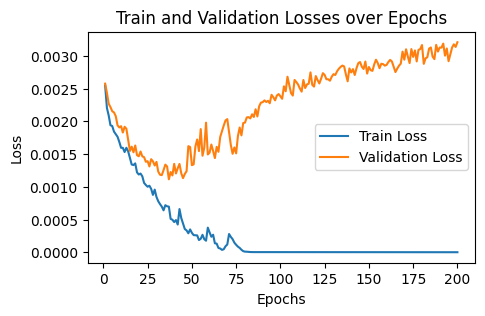

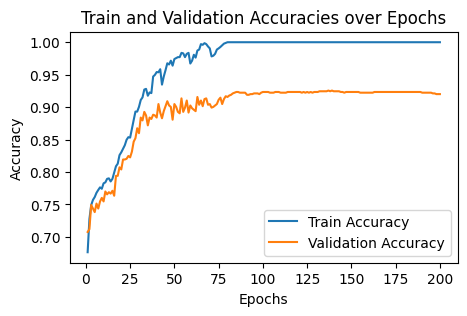

In [24]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH)
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH)

In [24]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/3000_GRU_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

100%|██████████| 4/4 [00:00<00:00, 542.32it/s]

Best epoch: 137
macro F1 Score: 0.9002747779891669
AUROC: 0.9437973718899324
Accuracy: 0.9048140043763676


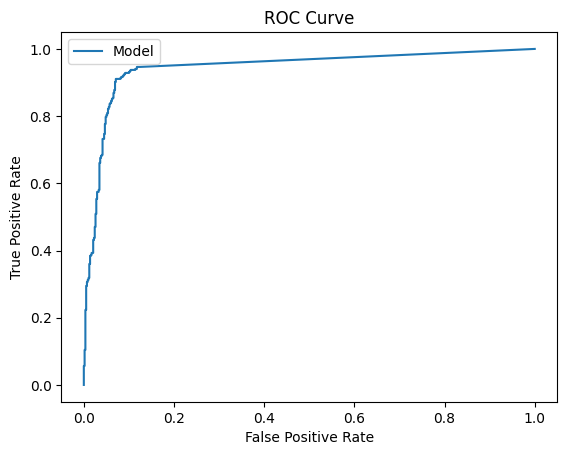

: 

In [28]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)